In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

#jax.config.update("jax_enable_x64", True)


import chainconsumer as cc

import numpyro as npy
import numpyro.distributions as dist
from numpyro.infer.reparam import LocScaleReparam

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior
from fitting import *
from plotting import *

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

In [3]:
wid = 64
oversample = 4

nwavels = 20
npoly=5

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

ddir = "../data/MAST_2024-09-22T03_37_01.724Z/HST/"


files = [
    #'n8yj53vfq_cal.fits'

    'n8yj59glq_cal.fits',

]

exposures_single = [exposure_from_file(ddir + file, SinglePointPolySpectrumFit(nwavels), crop=wid) for file in files]

exposures_binary = [exposure_from_file(ddir + file, BinaryPolySpectrumFit(nwavels), crop=wid) for file in files]

Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71   (256, 256)   float32   
None
Filename: ../data/MAST_2024-09-22T03_37_01.724Z/HST/n8yj59glq_cal.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     309   ()      
  1  SCI           1 ImageHDU       143   (256, 256)   float32   
  2  ERR           1 ImageHDU        71   (256, 256)   float32   
  3  DQ            1 ImageHDU        71   (256, 256)   int16   
  4  SAMP          1 ImageHDU        71   (256, 256)   int16   
  5  TIME          1 ImageHDU        71  

In [4]:
params = {
    #"fluxes": {},
    "positions": {},
    "spectrum": {},
    "aberrations": {},
    "cold_mask_shift": {},
    "cold_mask_rot": {},
    "cold_mask_scale": {},
    "cold_mask_shear": {},
    "primary_scale": {},
    "primary_rot": {},
    "primary_shear": {},
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
    "scale": 0.0432,
    "rot": 0.,
    "softening": 2.,
}

for exp in exposures_single:
    params["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params["spectrum"][exp.fit.get_key(exp, "spectrum")] = np.zeros(npoly).at[0].set(1)*np.log10(np.nansum(exp.data)/nwavels)
    params["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(26)
    params["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = -np.asarray([-0.06, -0.06])*1e2
    params["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = -45.
    params["cold_mask_scale"][exp.fit.get_key(exp, "cold_mask_scale")] = np.asarray([1.,1.])
    params["cold_mask_shear"][exp.fit.get_key(exp, "cold_mask_shear")] = np.asarray([0.,0.])
    params["primary_rot"][exp.fit.get_key(exp, "primary_rot")] = -45. #+ 180.
    params["primary_scale"][exp.fit.get_key(exp, "primary_scale")] = np.asarray([1.,1.])
    params["primary_shear"][exp.fit.get_key(exp, "primary_shear")] = np.asarray([0.,0.])

model_single = set_array(NICMOSModel(exposures_single, params, optics, detector))
model_binary = set_array(NICMOSModel(exposures_binary, params, optics, detector))


params = ModelParams(params)

In [5]:
def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

base_adam = lambda vals: optax.adam(vals)
opta = lambda lr, start, *schedule: base_adam(scheduler(lr, start, *schedule))


def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]



g = 5e-3

things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*30, 0),
    "spectrum": opt(g*20, 10),#, (20, 1.5)),
    "cold_mask_shift": opt(g*500, 120),
    "cold_mask_rot": opt(g*500, 120),
    #"cold_mask_scale": opt(g*3000, 150),
    #"cold_mask_shear": opt(g*1000, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    #"aberrations": opt(g*100,20),#, (150, g*0.2)),
    #"spectrum": opt(g*50, 20)#, (150, g*200), (200, g*300), (250, g*400)),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}

groups = list(things.keys())
paths = flatten(groups)
optimisers = [things[i] for i in groups]
groups = [list(x) if isinstance(x, tuple) else x for x in groups]

In [6]:
losses, models = optimise(params, model_single, exposures_single, things, 20)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

{'n8yj59glq': {'positions': Array([[5.5103206e+08, 1.9930128e+07],
       [1.9930082e+07, 4.1736787e+08]], dtype=float32), 'spectrum': Array([[ 8.64185139e+09, -5.29096544e+08,  3.20527002e+09,
        -2.90209568e+08,  2.13726195e+09],
       [-5.29096960e+08,  1.00697978e+09, -2.57153088e+08,
         6.60759616e+08, -1.81776864e+08],
       [ 3.20527027e+09, -2.57153088e+08,  1.46940877e+09,
        -1.56253856e+08,  1.05847706e+09],
       [-2.90209792e+08,  6.60759744e+08, -1.56253952e+08,
         5.11970176e+08, -1.16004000e+08],
       [ 2.13726208e+09, -1.81776816e+08,  1.05847706e+09,
        -1.16003920e+08,  8.00867968e+08]], dtype=float32), 'cold_mask_shift': Array([[-17909256. ,   2009371.1],
       [  2009371.8, -17942156. ]], dtype=float32), 'cold_mask_rot': Array([[-32487552.]], dtype=float32)}}
Fitting Model


  0%|          | 0/20 [00:00<?, ?it/s]

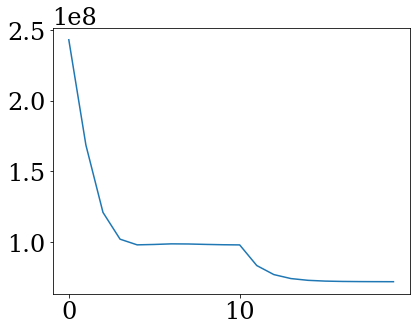

In [7]:
plt.plot(losses[-20:])

4


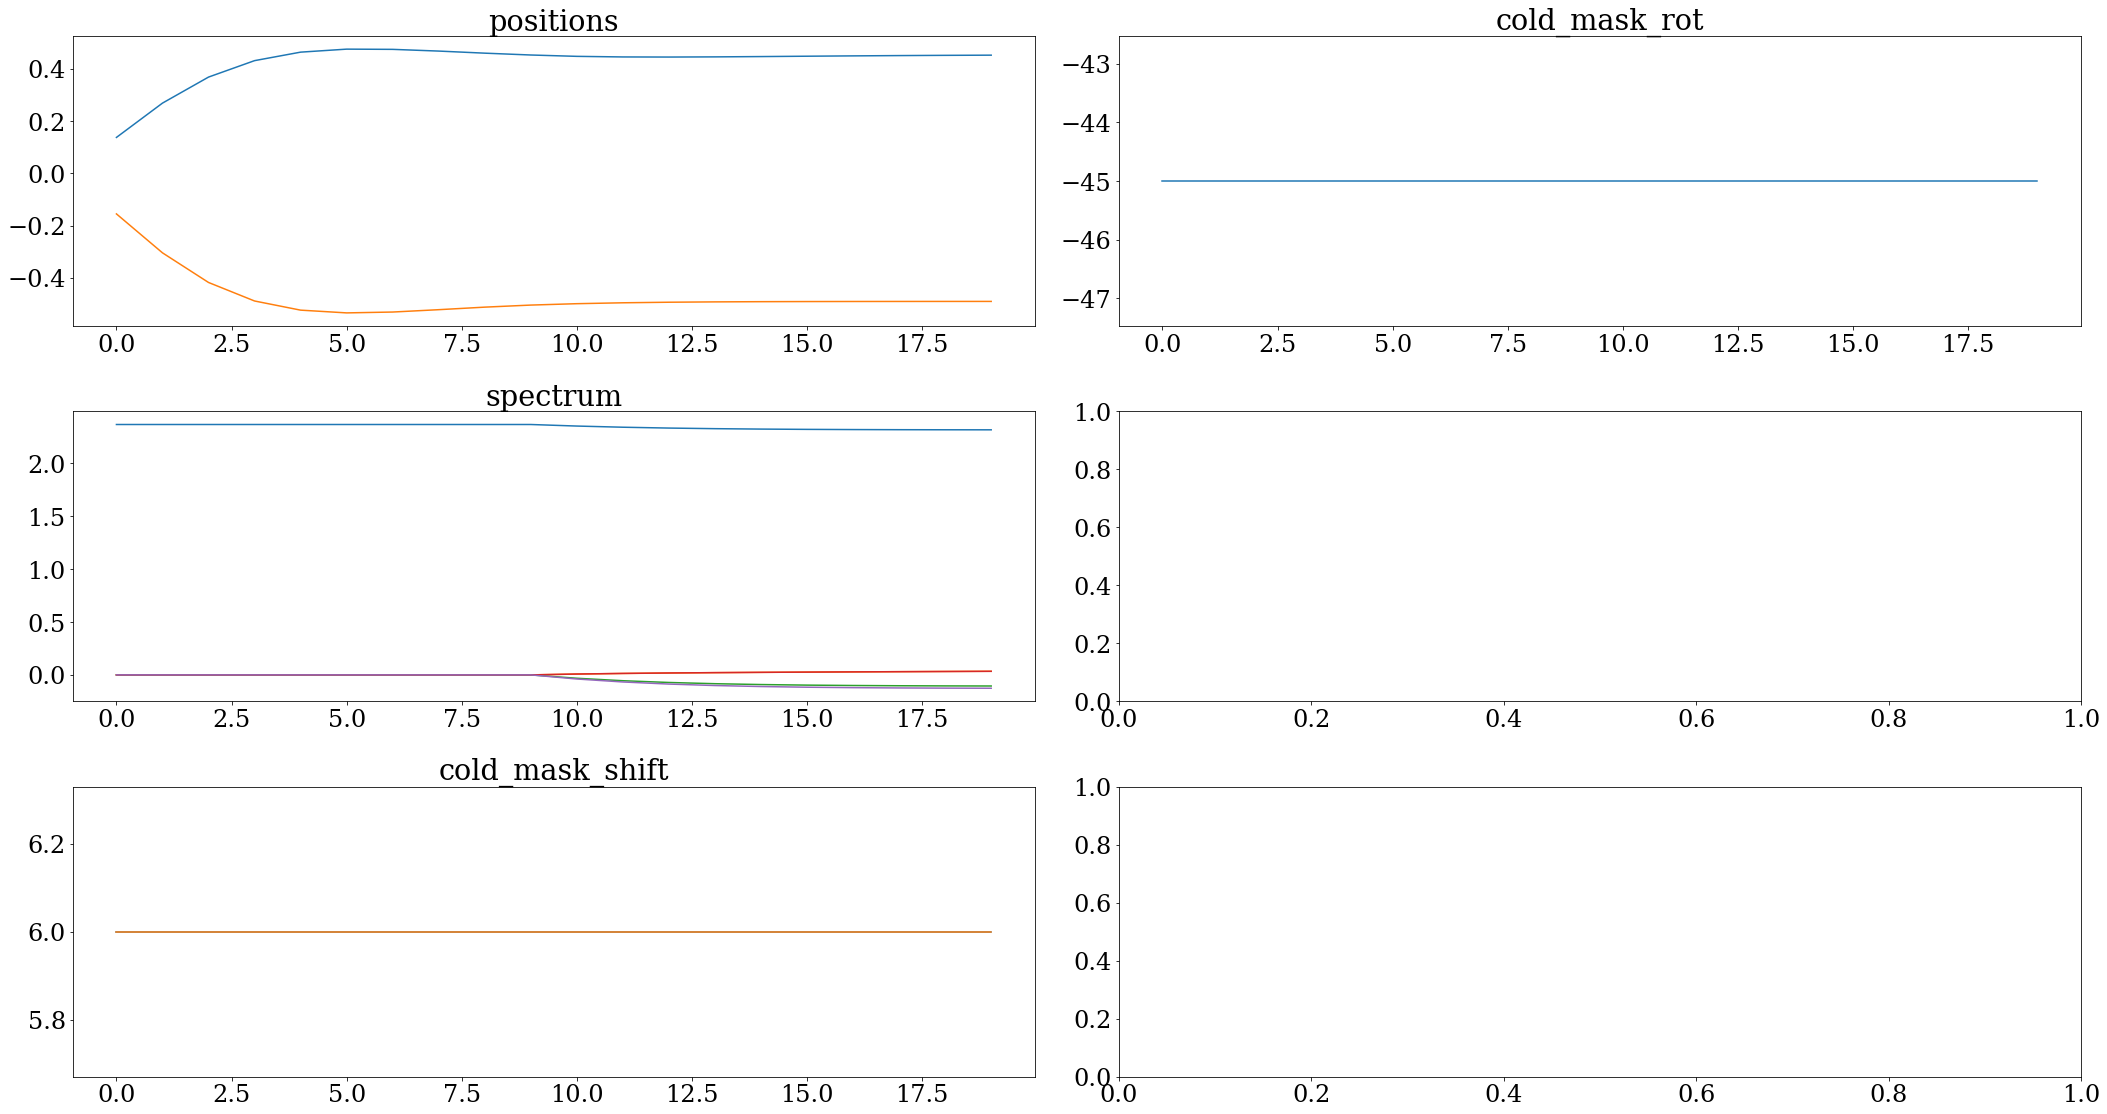

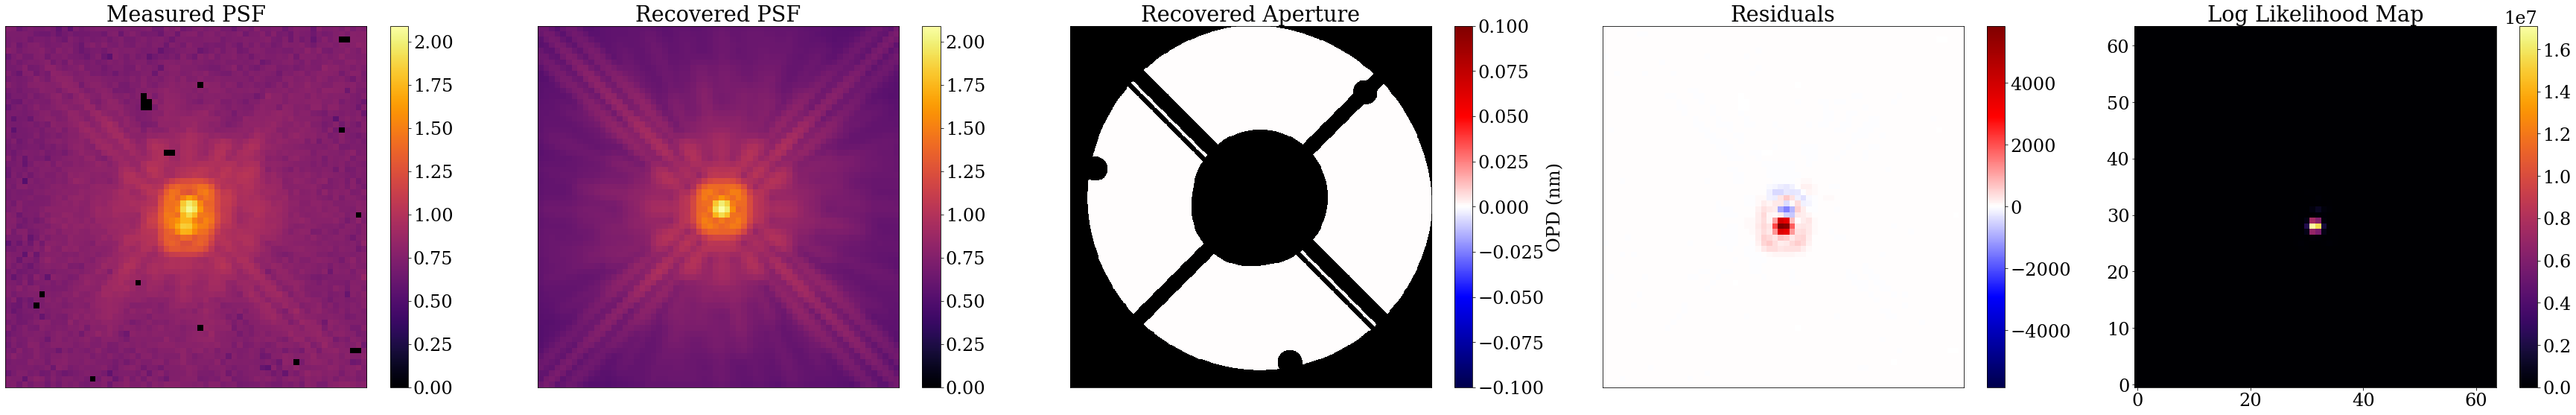

In [8]:
plot_params(models, groups, xw = 3)
plot_comparison(model_single, models[-1], exposures_single)

In [9]:
#potato

In [10]:
#plot_spectra(model_single, models[-1], exposures_single)

In [11]:
def tree_mul(spec, val):
    return jtu.tree_map(lambda x: x*val, spec)

def tree_sum(spec, val):
    return jtu.tree_map(lambda x: x+val, spec)


def extract_binary_params(params, exposures, x, y, theta, r, flux, contrast):
    #fluxes = dlu.fluxes_from_contrast(flux, contrast)
    param_dict = params.params.copy()
    param_dict["primary_spectrum"] = param_dict["spectrum"]
    param_dict["secondary_spectrum"] = param_dict["spectrum"]
    param_dict["fluxes"] = dlu.list2dictionary([(exp.fit.get_key(exp, "fluxes"), flux) for exp in exposures], ordered=True)#tree_mul(param_dict["spectrum"], fluxes[0])
    param_dict["contrast"] = dlu.list2dictionary([(exp.fit.get_key(exp, "contrast"), contrast) for exp in exposures], ordered=True) #tree_mul(param_dict["spectrum"], fluxes[1])
    param_dict["positions"] = tree_sum(param_dict["positions"], np.array([x,y]))
    param_dict["separation"] = r#dlu.list2dictionary([(exp.fit.get_key(exp, "separation"), r) for exp in exposures])
    param_dict["position_angle"] = theta #dlu.list2dictionary([(exp.fit.get_key(exp, "position_angle"), theta) for exp in exposures])
    return ModelParams(param_dict)


"""def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):
    fluxes = dlu.fluxes_from_contrast(flux, contrast)
    injected_params = ModelParams({
        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),
        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),
        "positions": np.asarray([x,y]),
        "position_angle": theta,
        "separation": r
    })
    return injected_params.inject(initial_params)
"""

'def inject_binary_values(x, y, theta, r, flux, contrast, initial_params):\n    fluxes = dlu.fluxes_from_contrast(flux, contrast)\n    injected_params = ModelParams({\n        "primary_spectrum": spectra_mul(initial_params.get("primary_spectrum"),fluxes[0]),\n        "secondary_spectrum": spectra_mul(initial_params.get("secondary_spectrum"),fluxes[1]),\n        "positions": np.asarray([x,y]),\n        "position_angle": theta,\n        "separation": r\n    })\n    return injected_params.inject(initial_params)\n'

In [12]:
binary_params = extract_binary_params(models[-1], exposures_binary, 0., 0., 0., 0., 0., 1.)
model_binary = set_array(NICMOSModel(exposures_binary, binary_params.params, optics, detector))


In [13]:
def loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))


In [14]:
#things = {"primary_spectrum": opt(4e-6, 0), "secondary_spectrum": opt(4e-6, 0)}#, "contrast": opt(1e-8, 10)}
things = {"fluxes": opt(5e-11, 0)}#, "contrast": opt(5e-11, 10)}

@zdx.filter_jit
@zdx.filter_value_and_grad(list(things.keys()))
def binary_loss_fn(params, exposures, model):
    mdl = params.inject(model)
    return np.nansum(np.asarray([posterior(mdl,exposure) for exposure in exposures]))

def binary_optimise(params, model, exposures, things, niter):
    paths = list(things.keys())
    optimisers = [things[i] for i in paths]
    
    optim, opt_state = zdx.get_optimiser(
        params, paths, optimisers
    )

    losses, models = [], []
    for i in (range(niter)):
        loss, grads = binary_loss_fn(params,exposures, model)
        #grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs.params))
        updates, opt_state = optim.update(grads, opt_state)
        params = zdx.apply_updates(params, updates)

        models.append(params)
        losses.append(loss)
    
    return losses, models

In [15]:
binary_params

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f32[26]},
    'cold_mask_rot':
    {'F110W': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'n8yj59glq': f32[2]},
    'outer_radius':
    1.146,
    'positions':
    {'n8yj59glq': f32[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'rot':
    0.0,
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'softening':
    2.0,
    'spectrum':
    {'U20081_F110W': f32[5]},
    'spider_width':
    0.0924,
    'primary_spectrum':
    {'U20081_F110W': f32[5]},
    'secondary_spectrum':
    {'U20081_F110W': f32[5]},
    'fluxes':
    {'U20081_F110W': 0.0},
    'contrast':
    {'F110W': 1.0},
    'separation':
    0.0,
    'position_angle':
    0.0
  }
)

In [16]:
x_vals = np.linspace(-5, 5, 4)
y_vals = np.linspace(-5, 5, 4)
theta_vals = np.arange(4)*np.pi/2#np.linspace(0, 2*np.pi, 4)
r_vals = np.asarray([1.5, 3])#np.linspace(0, 5, 2)

min_loss = np.inf
best_params = None

for x in x_vals:
    for y in y_vals:
        for theta in theta_vals:
            for r in r_vals:
                binary_params = extract_binary_params(models[-1], exposures_binary, x, y, theta, r, 0., 1.)
                #binary_params = extract_binary_params(models[-1], exposures_binary, 0, 0, 0, 0, 0., 1.)#np.log10(0.5), 1.)
                losses, bms = binary_optimise(binary_params, model_binary, exposures_binary, things, 20)
                print(losses[-1])
                if losses[-1] < min_loss and min_loss != 0.0:
                    min_loss = losses[-1]
                    best_params = bms[-1]
                

352378940.0
353146850.0
352367100.0
353062850.0
352354530.0
352974660.0
352341220.0
352882720.0
346743070.0
347511500.0
346737250.0
347475000.0
346729200.0
347430500.0
346719040.0
347378400.0
351433100.0
352235200.0
351445920.0
352323680.0
351457600.0
352405800.0
351468030.0
352481020.0
356832580.0
359066750.0
356846850.0
359148100.0
356861020.0
359226000.0
356874750.0
359300130.0
324021540.0
302111940.0
323767780.0
300889600.0
323523970.0
299703520.0
323290880.0
298560500.0
251474740.0
212996820.0
251379120.0
212308160.0
251294500.0
211635920.0
251221120.0
210981550.0
310844540.0
298232130.0
311247140.0
299880350.0
311645760.0
301489570.0
312039360.0
303055680.0
352680030.0
352104580.0
352675840.0
352086340.0
352672640.0
352072030.0
352670560.0
352061920.0
337927330.0
330942980.0
338022340.0
331350080.0
338117600.0
331744930.0
338212800.0
332127550.0
293144830.0
265510220.0
293397470.0
266842690.0
293644350.0
268120580.0
293884600.0
269338140.0
306984500.0
290790820.0
306504000.0
2888

In [17]:
best_params

ModelParams(
  params={
    'aberrations':
    {'n8yj59glq': f32[26]},
    'cold_mask_rot':
    {'F110W': f32[]},
    'cold_mask_scale':
    {'F110W': f32[2]},
    'cold_mask_shear':
    {'F110W': f32[2]},
    'cold_mask_shift':
    {'n8yj59glq': f32[2]},
    'contrast':
    {'F110W': 1.0},
    'fluxes':
    {'U20081_F110W': f32[]},
    'outer_radius':
    1.146,
    'position_angle':
    f32[],
    'positions':
    {'n8yj59glq': f32[2]},
    'primary_rot':
    {'F110W': -45.0},
    'primary_scale':
    {'F110W': f32[2]},
    'primary_shear':
    {'F110W': f32[2]},
    'primary_spectrum':
    {'U20081_F110W': f32[5]},
    'rot':
    0.0,
    'scale':
    0.0432,
    'secondary_radius':
    0.44639999999999996,
    'secondary_spectrum':
    {'U20081_F110W': f32[5]},
    'separation':
    f32[],
    'softening':
    2.0,
    'spectrum':
    {'U20081_F110W': f32[5]},
    'spider_width':
    0.0924
  }
)

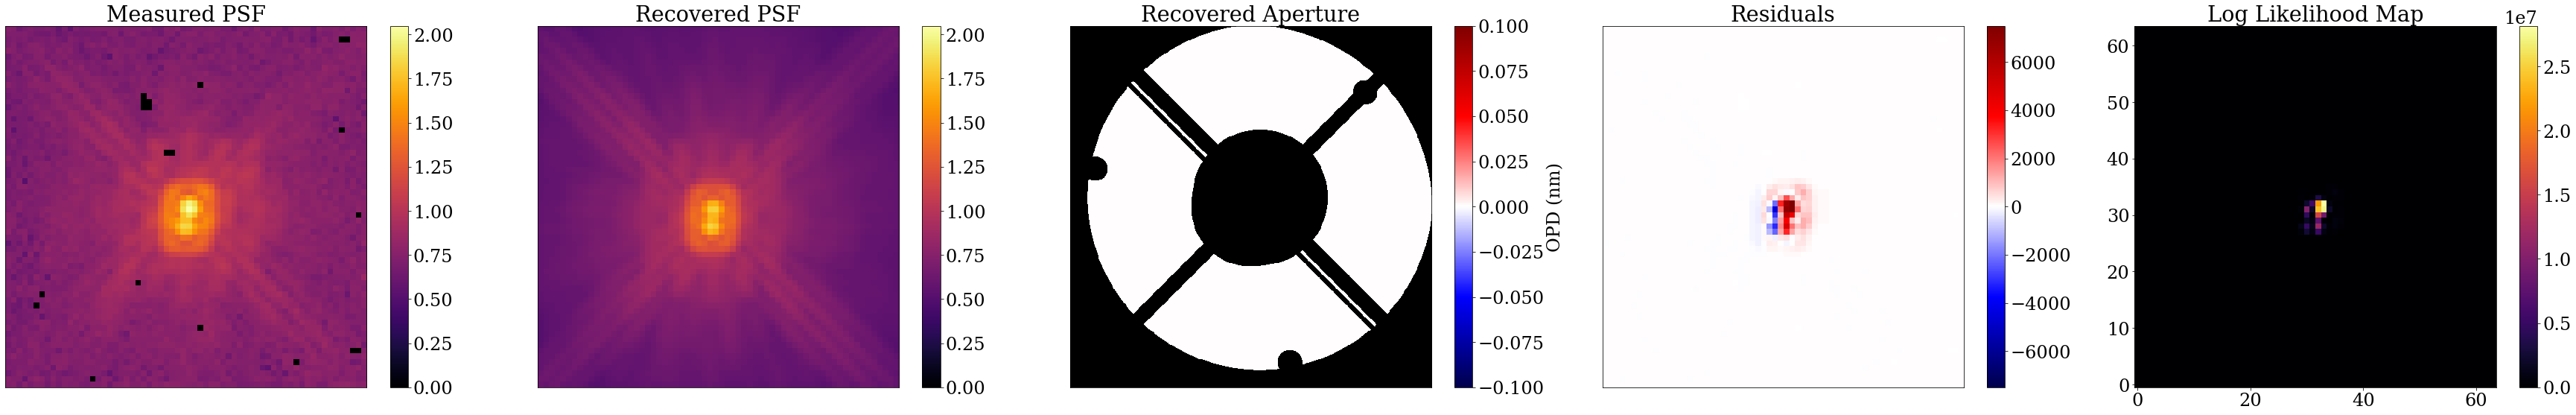

In [18]:
plot_comparison(model_binary, best_params, exposures_binary)

In [25]:
g = 5e-3
things = {
    #"fluxes" : opt(g*20,10),
    "positions": opt(g*100, 0),
    "separation": opt(g*30, 0),
    "position_angle": opt(g*1e-4, 10),
    "primary_spectrum": opt(g*50, 20),
    "secondary_spectrum": opt(g*50, 20),#, (20, 1.5)),
    "cold_mask_shift": opt(g*500, 120),
    "cold_mask_rot": opt(g*500, 120),
    #"cold_mask_scale": opt(g*3000, 150),
    #"cold_mask_shear": opt(g*1000, 150),
    #"primary_scale": opt(g*100, 150),
    #"primary_rot": opt(g*100, 150),
    #"primary_shear": opt(g*100, 150),
    "aberrations": opt(g*100,30),#, (150, g*0.2)),
    #"spectrum": opt(g*50, 20)#, (150, g*200), (200, g*300), (250, g*400)),
    #"spectrum": opt(g*0.01, 20),
    #"softening": opt(g*1e3, 200),
    #"breathing": opt(g*1000,150),
    #"rot": opt(g*100, 50),
}
groups = list(things.keys())


In [26]:
losses, models = optimise(best_params, set_array(model_binary), exposures_binary, things, 300)

Calculating Fishers


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

{'n8yj59glq': {'positions': Array([[ 1.5889548e+09, -4.7056695e+06],
       [-4.7056425e+06,  1.2931639e+09]], dtype=float32), 'separation': Array([[-1.370191e+08]], dtype=float32), 'position_angle': Array([[0.]], dtype=float32), 'primary_spectrum': Array([[5.9696128e+09, 4.0280032e+07, 1.8774787e+09, 6.0563616e+07,
        1.1527075e+09],
       [4.0280032e+07, 9.6230752e+08, 2.5950592e+07, 5.8650054e+08,
        2.4985888e+07],
       [1.8774784e+09, 2.5950552e+07, 8.7134848e+08, 3.4472944e+07,
        6.1509530e+08],
       [6.0563560e+07, 5.8650048e+08, 3.4472920e+07, 4.3848000e+08,
        3.0642000e+07],
       [1.1527075e+09, 2.4985832e+07, 6.1509536e+08, 3.0641992e+07,
        4.7157510e+08]], dtype=float32), 'secondary_spectrum': Array([[5.9696128e+09, 4.0280032e+07, 1.8774787e+09, 6.0563616e+07,
        1.1527075e+09],
       [4.0280032e+07, 9.6230752e+08, 2.5950592e+07, 5.8650054e+08,
        2.4985888e+07],
       [1.8774784e+09, 2.5950552e+07, 8.7134848e+08, 3.4472944e+07,

  0%|          | 0/300 [00:00<?, ?it/s]

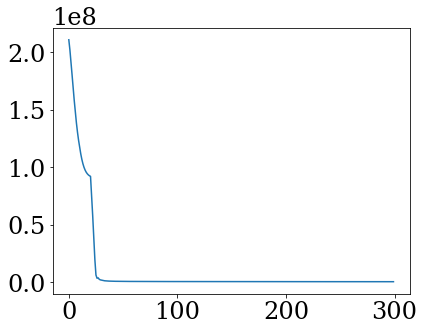

In [27]:
plt.plot(losses)

8


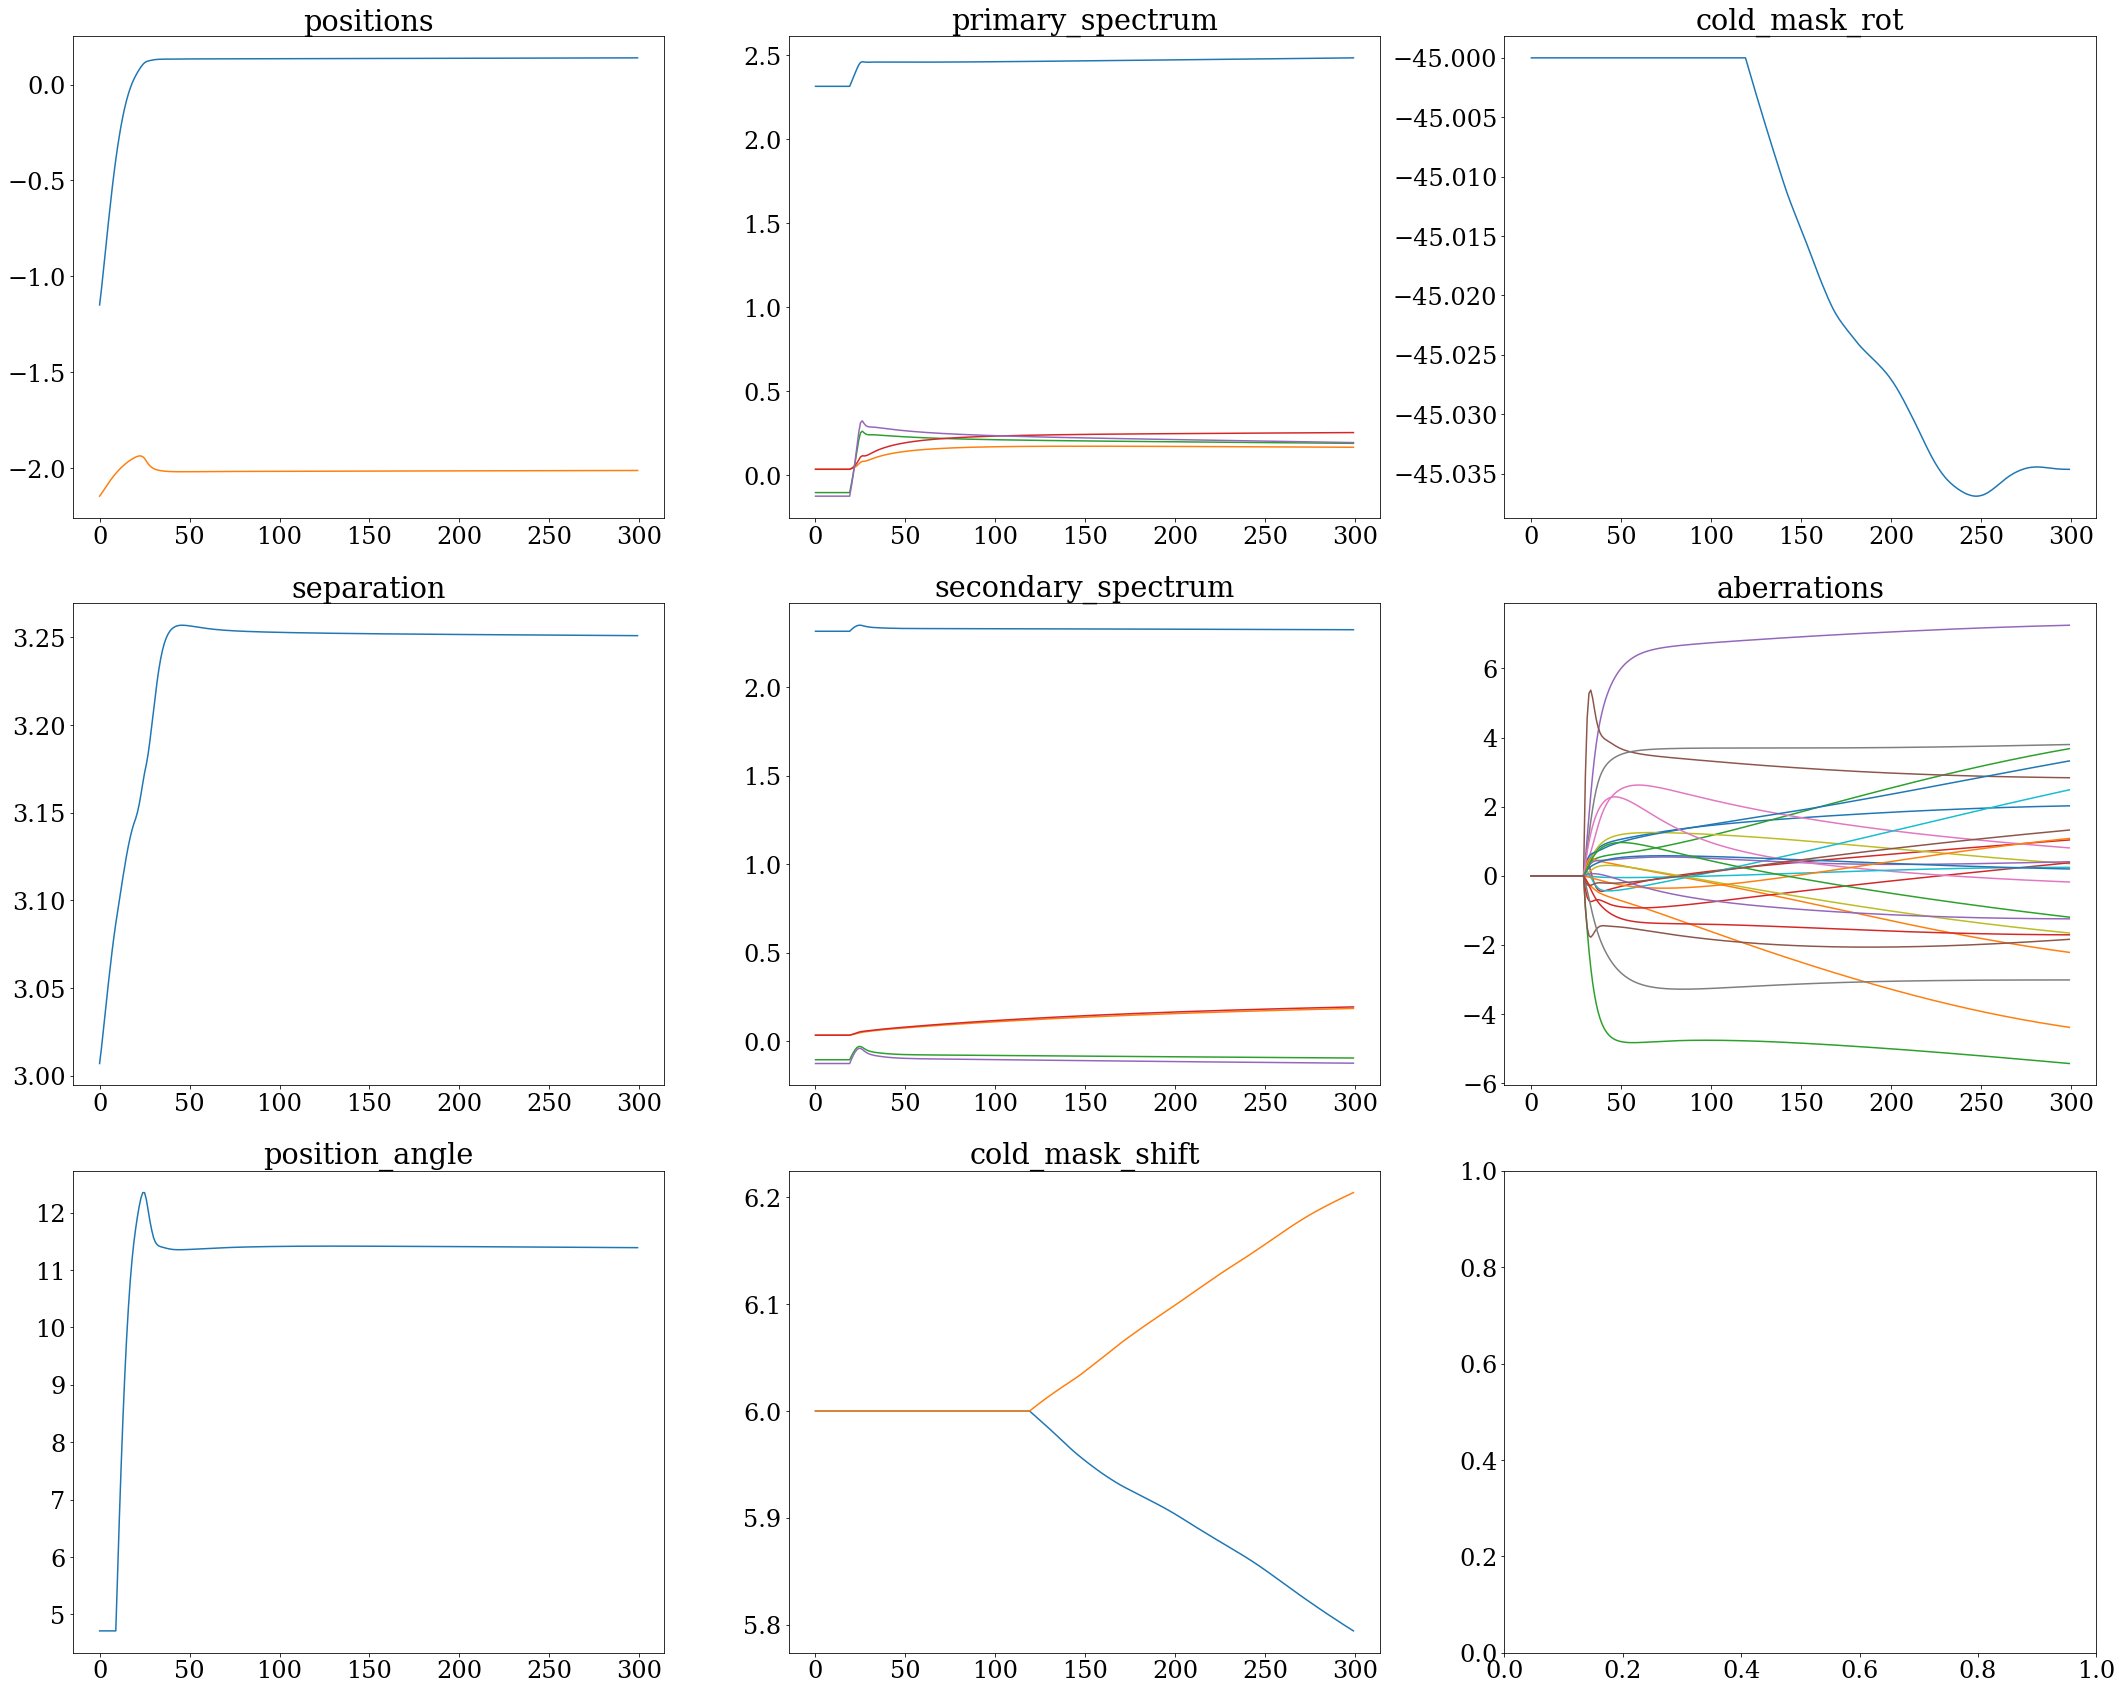

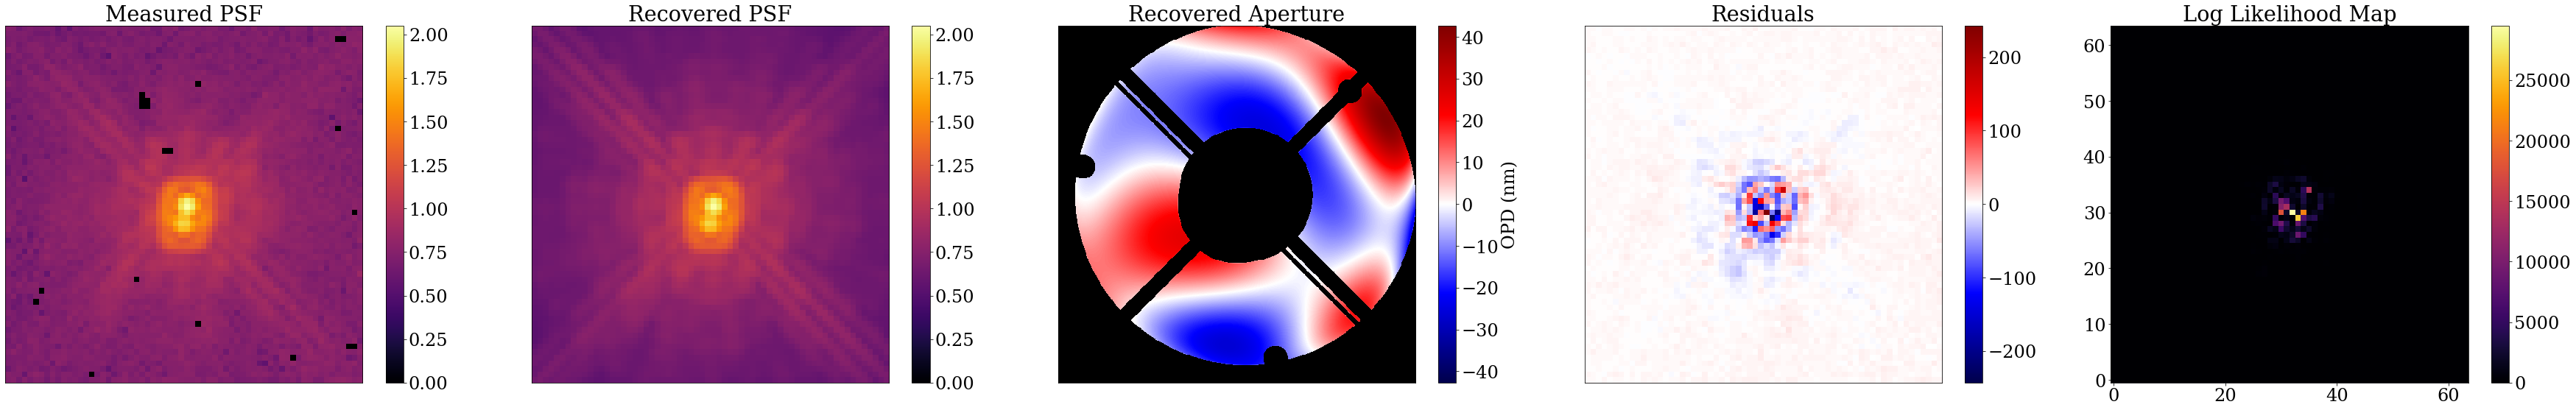

In [28]:
plot_params(models, groups, xw = 3)
plot_comparison(model_binary, models[-1], exposures_binary)

In [29]:
models[-1].params

{'aberrations': {'n8yj59glq': Array([ 2.0233936 , -4.386621  ,  3.6784196 ,  1.0359763 ,  7.250964  ,
          2.8373268 ,  0.8066108 ,  3.798348  ,  0.35064954,  2.487136  ,
          3.3236616 , -2.217277  , -5.4342465 ,  0.37613407,  0.40551618,
         -1.8395935 , -0.18091205, -3.0154598 , -1.6579572 ,  0.24283227,
          0.19626713,  1.0796838 , -1.197672  , -1.7097539 , -1.2466948 ,
          1.3233943 ], dtype=float32)},
 'cold_mask_rot': {'F110W': Array(-45.03465, dtype=float32)},
 'cold_mask_scale': {'F110W': Array([1., 1.], dtype=float32)},
 'cold_mask_shear': {'F110W': Array([0., 0.], dtype=float32)},
 'cold_mask_shift': {'n8yj59glq': Array([5.7941465, 6.20451  ], dtype=float32)},
 'contrast': OrderedDict([('F110W', 1.0)]),
 'fluxes': OrderedDict([('U20081_F110W', Array(-0.4667914, dtype=float32))]),
 'outer_radius': 1.146,
 'position_angle': Array(11.388344, dtype=float32),
 'positions': {'n8yj59glq': Array([ 0.13945624, -2.0122101 ], dtype=float32)},
 'primary_rot': 

Text(0, 0.5, 'Relative Spectral Intensity')

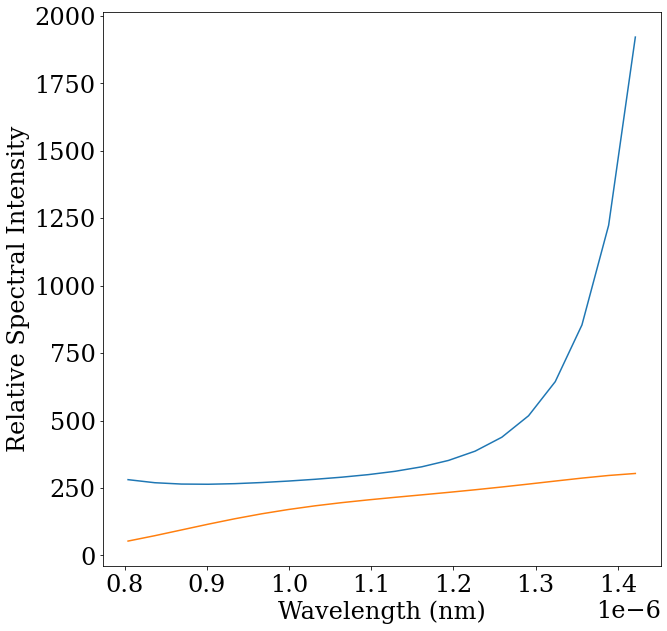

In [30]:
plt.figure(figsize=(10,10))

wv, filt = calc_throughput("F110W", nwavels=nwavels)

#plt.plot(wavels, params.get("spectrum.U10764_F110W"))
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("primary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)
plt.plot(wv, 10**(NonNormalisedClippedPolySpectrum(np.linspace(-1, 1, nwavels), models[-1].get("secondary_spectrum.U20081_F110W")).weights))#), yerr = spectrum_err)

plt.xlabel("Wavelength (nm)")
plt.ylabel("Relative Spectral Intensity")